# Imports

In [1]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer

In [2]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

In [3]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(configs['model']['save_dir']):
            os.makedirs(configs['model']['save_dir'])

In [4]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_ciclo1_multiclass_aug_dim_135_TIs_TargetPerc.pkl')
print(df.shape)
df.head(2)

(139884, 135)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,122.7500,160.0,11,2,2,15.0,HOLD,1,106.82,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,126.8625,205.0,11,2,2,50.0,HOLD,1,106.83,HOLD


## Split dos Dados

In [5]:
df.columns.tolist()
df.columns.array

<PandasArray>
[             'DATETIME',                  'DATE',                  'TIME',
                  'OPEN',                  'HIGH',                   'LOW',
                 'CLOSE',                   'VOL',        'BBANDS_Upper_5',
        'BBANDS_Lower_5',
 ...
                'ATR_20',                'TRANGE',                   'MES',
            'DIA_SEMANA',            'HORA_NOBRE',            'TARGET_WIN',
       'TARGET_WIN_CAT3', 'TARGET_WIN_CAT3_LABEL',      'PRICE_PERCENTAGE',
     'TARGET_PERCENTAGE']
Length: 135, dtype: object

In [6]:
print(df.shape)
df2 = df.drop([  'OPEN',                  
                 'HIGH',                   
                 'LOW',
                 'CLOSE',                   
                 'VOL',
                 'MES',
                 'TARGET_WIN',
                 'TARGET_WIN_CAT3', 
                 'TARGET_WIN_CAT3_LABEL',      
                 'PRICE_PERCENTAGE'
               
            
              ], axis=1)
print(df2.shape)
df2.head(2)

(139884, 135)
(139884, 125)


,DATETIME,DATE,TIME,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53752.526189,53227.473811,53701.563032,53003.436968,53582.216054,52961.783946,53513.521581,...,224.882410,16995.0,183.08836,157.567344,133.163314,122.7500,160.0,2,2,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53712.281525,53317.718475,53699.874976,53060.125024,53596.604149,52972.395851,53498.711770,...,-968.557883,24029.0,190.39224,165.472787,139.149704,126.8625,205.0,2,2,HOLD


In [7]:
df3 = df2[df2['DATETIME'].dt.year < 2020]
df3.drop(['DATE', 'TIME'], axis=1, inplace=True)
df4 = df3[df3['DATETIME'].dt.year > 2014].reset_index(drop=True)
#df4

C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
df_train = df2[(df2['DATETIME'] >= '2015-01-01') & (df2['DATETIME'] < '2018-01-01')]
#df_train = df2[(df2['DATETIME'] >= '2017-12-01') & (df2['DATETIME'] < '2019-07-01')]
#df_train = df_train.iloc[-10000:, :]

df_train = df2[(df2['DATETIME'] >= '2019-01-01') & (df2['DATETIME'] < '2019-09-01')]

#----------------------------------------------------------------------------------------------------

df_valid = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-01-01')]
#df_valid = df2[(df2['DATETIME'] >= '2019-07-01') & (df2['DATETIME'] < '2020-03-01')]
#df_valid = df_valid.iloc[:6600, :]

df_valid = df2[(df2['DATETIME'] >= '2019-09-01') & (df2['DATETIME'] < '2020-01-01')]

#----------------------------------------------------------------------------------------------------

df_test  = df2[(df2['DATETIME'] >= '2019-01-01') & (df2['DATETIME'] < '2020-01-01')]
#df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#df_test  = df2[(df2['DATETIME'] < '2017-12-01')]
#df_test = df_test.iloc[:500,:]

df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#----------------------------------------------------------------------------------------------------

print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_valid['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_test['DATETIME'].count()/df2['DATETIME'].count()))

df_train.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_valid.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_test.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
print(df_train.shape, df_valid.shape, df_test.shape)

Proporção Train: 12.8% | Validation: 6.4% | Test: 2.9%
(17849, 122) (8889, 122) (4067, 122)


C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
df_test.iloc[19:200].head(1)

,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
135836,117489.521929,116862.478071,117397.405807,116813.594193,117349.698893,116850.801107,117269.240037,117228.122937,117137.461639,117010.529854,...,95344.558922,-7850190.0,212.171216,205.912372,197.823329,186.913789,165.0,3,1,HOLD


In [10]:
df_train['TARGET_PERCENTAGE'].value_counts()

HOLD    13877
BUY      2041
SELL     1931
Name: TARGET_PERCENTAGE, dtype: int64

In [11]:
df_train['TARGET_PERCENTAGE'].value_counts()[0]

13877

In [12]:
hold_train = df_train['TARGET_PERCENTAGE'].value_counts()[0]
hold_valid = df_valid['TARGET_PERCENTAGE'].value_counts()[0]
hold_test = df_test['TARGET_PERCENTAGE'].value_counts()[0]

print('\nDados Categóricos de Treino -- BUY: %d | SELL: %d | HOLD: %d' % (df_train['TARGET_PERCENTAGE'].value_counts()[1], df_train['TARGET_PERCENTAGE'].value_counts()[2], hold_train))
print('\nDados Categóricos de Validação -- BUY: %d | SELL: %d | HOLD: %d' % (df_valid['TARGET_PERCENTAGE'].value_counts()[1], df_valid['TARGET_PERCENTAGE'].value_counts()[2], hold_valid))
print('\nDados Categóricos de Teste -- BUY: %d | SELL: %d | HOLD: %d' % (df_test['TARGET_PERCENTAGE'].value_counts()[1], df_test['TARGET_PERCENTAGE'].value_counts()[2], hold_test))



Dados Categóricos de Treino -- BUY: 2041 | SELL: 1931 | HOLD: 13877

Dados Categóricos de Validação -- BUY: 625 | SELL: 522 | HOLD: 7742

Dados Categóricos de Teste -- BUY: 380 | SELL: 355 | HOLD: 3332


In [13]:
df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()

HORA_NOBRE  TARGET_PERCENTAGE
0           HOLD                  779
            SELL                  106
            BUY                   101
1           HOLD                 3448
            BUY                   757
            SELL                  745
2           HOLD                 9650
            BUY                  1183
            SELL                 1080
Name: TARGET_PERCENTAGE, dtype: int64

In [14]:
buy_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

buy_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

buy_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

print('\nDados Categóricos de Treino Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_train, sell_train, hold_train))
print('\nDados Categóricos de Validação Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_valid, sell_valid, hold_valid))
print('\nDados Categóricos de Teste Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_test, sell_test, hold_test))



Dados Categóricos de Treino Hora Nobre -- BUY: 757 | SELL: 745 | HOLD: 3448

Dados Categóricos de Validação Hora Nobre -- BUY: 268 | SELL: 234 | HOLD: 1958

Dados Categóricos de Teste Hora Nobre -- BUY: 146 | SELL: 129 | HOLD: 835


In [15]:
np.random.seed(2345)
porcentagem_selecao_train = (buy_train / hold_train)
amostra_train = np.random.choice( a=[0,1], size=hold_train, replace=True, 
                                   p=[1-porcentagem_selecao_train, porcentagem_selecao_train] )
print(len(amostra_train))
print(len(amostra_train[amostra_train == 1]))
print(len(amostra_train[amostra_train == 0]))

3448
754
2694


In [16]:
np.random.seed(2345)
porcentagem_selecao_valid = (buy_valid / hold_valid)
amostra_valid = np.random.choice( a=[0,1], size=hold_valid, replace=True, 
                                   p=[1-porcentagem_selecao_valid, porcentagem_selecao_valid] )
print(len(amostra_valid))
print(len(amostra_valid[amostra_valid == 1]))
print(len(amostra_valid[amostra_valid == 0]))

1958
267
1691


In [17]:
np.random.seed(2345)
porcentagem_selecao_test = (buy_test / hold_test)
amostra_test = np.random.choice( a=[0,1], size=hold_test, replace=True, 
                                   p=[1-porcentagem_selecao_test, porcentagem_selecao_test] )
print(len(amostra_test))
print(len(amostra_test[amostra_test == 1]))
print(len(amostra_test[amostra_test == 0]))

835
143
692


In [18]:
def normalize(data):

    scaler_x = StandardScaler()

    x = data.iloc[:, :-2]
    x = scaler_x.fit_transform(x) 

    y = data.iloc[:,-1]
    y_list = np.array(y.to_list())

    return x, y_list

In [19]:
def get_train_valid_test_data(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    for i in range(len(df) - seq_len):
        if df['TARGET_PERCENTAGE'][i+seq_len-1] == 'HOLD':
            if amostragem[a] == 0:
                df.drop((i+seq_len-1), axis=0, inplace=True) 
            a+=1

    x, y = normalize(df)

    return x, y

In [20]:
def next_window(i, seq_len, df):
    df = df[i:i+seq_len]
    scaler_x = StandardScaler()
    
    x = df.iloc[:, :-2]
    # xxx = np.array(x)
    x = scaler_x.fit_transform(x) 
    
    y = df.iloc[-1,-1]
    # y_list = np.array(y.to_list())
    
    return x, y

In [21]:
def get_train_valid_test_data_Slide_Window(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    data_x = []
    data_y = []
    for i in range(len(df) - seq_len):
        if df['TARGET_PERCENTAGE'].iloc[i+seq_len-1] == 'HOLD':
            if amostragem[a] == 1:    
                x, y = next_window(i, seq_len, df)
                data_x.append(x)
                data_y.append(y)
            a+=1
        else:
            x, y = next_window(i, seq_len, df)
            data_x.append(x)
            data_y.append(y)

    return np.array(data_x), np.array(data_y)

In [22]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train, y_train = get_train_valid_test_data(seq_len=1, 
                                             df=df_train_reset_index, 
                                             amostragem=amostra_train)
print('x_train: ', x_train.shape,' | y_train: ', y_train.shape)

df.shape:  (4950, 122)
x_train:  (2256, 120)  | y_train:  (2256,)


In [23]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train_sw, y_train_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_train_reset_index, 
                                                                 amostragem=amostra_train)
print('x_train_sw: ', x_train_sw.shape,' | y_train_sw: ', y_train_sw.shape)

df.shape:  (4950, 122)
x_train_sw:  (2246, 20, 120)  | y_train_sw:  (2246,)


In [24]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid, y_valid = get_train_valid_test_data( seq_len=1, 
                                              df=df_valid_reset_index, 
                                              amostragem=amostra_valid )
print(x_valid.shape, y_valid.shape)

df.shape:  (2460, 122)
(769, 120) (769,)


In [25]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid_sw, y_valid_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_valid_reset_index, 
                                                                 amostragem=amostra_valid )
print(x_valid_sw.shape, y_valid_sw.shape)

df.shape:  (2460, 122)
(759, 20, 120) (759,)


In [26]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test, y_test = get_train_valid_test_data( seq_len=1, 
                                            df=df_test_reset_index, 
                                            amostragem=amostra_test )
print(x_test.shape, y_test.shape)

df.shape:  (1110, 122)
(419, 120) (419,)


In [27]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test_sw, y_test_sw = get_train_valid_test_data_Slide_Window(   seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_test_reset_index, 
                                                                 amostragem=amostra_test)
print(x_test_sw.shape, y_test_sw.shape)

df.shape:  (1110, 122)
(411, 20, 120) (411,)


In [28]:
def contagem_classes(data, name):
    cont_buy = 0
    cont_sell = 0
    cont_hold = 0
    for n in data:
        if ((n == 'BUY') or (n == 0)):
            cont_buy+=1
        if ((n == 'HOLD') or (n == 1)):
            cont_hold+=1
        if ((n == 'SELL') or (n == 2)):
            cont_sell+=1
    print('{}.size: '.format(name), data.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

In [29]:
print('Contagem de Classes\n')
print('-----------------------------------------------------------------------------------')
contagem_classes(y_train, 'y_train   ')
contagem_classes(y_train_sw, 'y_train_sw')
print('-----------------------------------------------------------------------------------')
contagem_classes(y_valid, 'y_valid   ')
contagem_classes(y_valid_sw, 'y_valid_sw')
print('-----------------------------------------------------------------------------------')
contagem_classes(y_test, 'y_test   ')
contagem_classes(y_test_sw, 'y_test_sw')
print('-----------------------------------------------------------------------------------')

Contagem de Classes

-----------------------------------------------------------------------------------
y_train   .size:  2256  | cont_buy:  757  | cont_hold:  754  | cont_sell:  745
y_train_sw.size:  2246  | cont_buy:  753  | cont_hold:  749  | cont_sell:  744
-----------------------------------------------------------------------------------
y_valid   .size:  769  | cont_buy:  268  | cont_hold:  267  | cont_sell:  234
y_valid_sw.size:  759  | cont_buy:  263  | cont_hold:  266  | cont_sell:  230
-----------------------------------------------------------------------------------
y_test   .size:  419  | cont_buy:  129  | cont_hold:  144  | cont_sell:  146
y_test_sw.size:  411  | cont_buy:  125  | cont_hold:  140  | cont_sell:  146
-----------------------------------------------------------------------------------


## Cálculo do Weighted F Score

In [30]:
def weightedFScore(confusion_matrix):
    beta_1 = math.pow(0.5, 2)
    beta_2 = math.pow(0.25, 2)
    beta_3 = math.pow(0.125, 2)
    
    num_tu = confusion_matrix[[0],[0]]
    num_tf = confusion_matrix[[1],[1]]
    num_td = confusion_matrix[[2],[2]]
    
    wrongF_trueU = confusion_matrix[[0],[1]]
    wrongD_trueU = confusion_matrix[[0],[2]]
    
    wrongU_trueF = confusion_matrix[[1],[0]]
    wrongD_trueF = confusion_matrix[[1],[2]]
  
    wrongU_trueD = confusion_matrix[[2],[0]]
    wrongF_trueD = confusion_matrix[[2],[1]]
    
    num_tp = num_tu + num_td + (beta_3 * num_tf)
    erro_tipo_1 = wrongU_trueD + wrongD_trueU
    erro_tipo_2 = wrongU_trueF + wrongD_trueF
    erro_tipo_3 = wrongF_trueU + wrongF_trueD
    
    num = (1 + beta_1 + beta_2) * num_tp
    den = num + erro_tipo_1 + (beta_1 * erro_tipo_2) + (beta_2 * erro_tipo_3)
    
    wFScore = num / den
    
    return wFScore

# Modelos

In [31]:
import lightgbm as lgbm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## LightGBM

In [32]:
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1, random_state=0, n_estimators=5, learning_rate=0.001, num_leaves=2**6,
                                 subsample=0.9, subsample_freq=1, colsample_bytree=1.)

model_lgbm.fit(x_train, y_train)
predict_lgbm = model_lgbm.predict(x_test)

accuracy_score_LGBM = accuracy_score(y_test, predict_lgbm)

print('Accuracy Score - LightGBM: ', accuracy_score_LGBM)

Accuracy Score - LightGBM:  0.315035799522673


In [33]:
print(classification_report(y_test, predict_lgbm))

              precision    recall  f1-score   support

         BUY       0.31      0.88      0.45       129
        HOLD       0.39      0.13      0.20       144
        SELL       0.00      0.00      0.00       146

    accuracy                           0.32       419
   macro avg       0.23      0.34      0.22       419
weighted avg       0.23      0.32      0.21       419



C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_lgbm, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[113,  16,   0],
       [125,  19,   0],
       [132,  14,   0]], dtype=int64)

In [35]:
print('Contagem de Classes -> predict_lgbm\n')
contagem_classes(predict_lgbm, 'predict_lgbm')

Contagem de Classes -> predict_lgbm

predict_lgbm.size:  419  | cont_buy:  370  | cont_hold:  49  | cont_sell:  0


<AxesSubplot:>

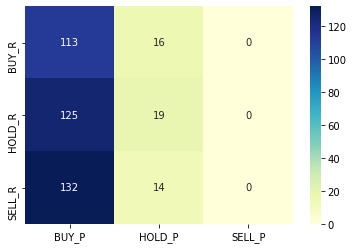

In [36]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LGBM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

In [37]:
weightedFScore_LGBM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LGBM

0.4738345588578506

### Compare train and test set accuracy

In [38]:
#y_pred_train = model_lgbm.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [39]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_lgbm.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_lgbm.score(x_test, y_test)))

In [40]:
#print('Validation set score: {:.4f}'.format(model_lgbm.score(x_valid, y_valid)))

## Random Forest

In [41]:
model_randomF = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=5)
model_randomF.fit(x_train, y_train)
predict_randomF = model_randomF.predict(x_test)

accuracy_score_RF = accuracy_score(y_test, predict_randomF)
print('Accuracy Score - Random Forest: ', accuracy_score_RF)

Accuracy Score - Random Forest:  0.34844868735083534


In [42]:
print(classification_report(y_test, predict_randomF))

              precision    recall  f1-score   support

         BUY       0.29      0.39      0.33       129
        HOLD       0.37      0.39      0.38       144
        SELL       0.42      0.27      0.33       146

    accuracy                           0.35       419
   macro avg       0.36      0.35      0.35       419
weighted avg       0.36      0.35      0.35       419



In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_randomF, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[50, 49, 30],
       [62, 56, 26],
       [59, 47, 40]], dtype=int64)

In [44]:
print('Contagem de Classes -> predict_randomF\n')
contagem_classes(predict_randomF, 'predict_randomF')

Contagem de Classes -> predict_randomF

predict_randomF.size:  419  | cont_buy:  171  | cont_hold:  152  | cont_sell:  96


<AxesSubplot:>

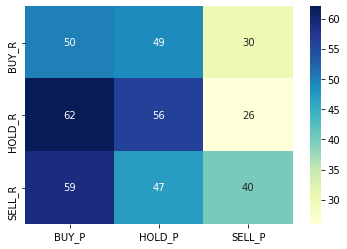

In [45]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_RF = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

In [46]:
weightedFScore_RF = weightedFScore(confusion_matrix)[0] 
weightedFScore_RF

0.5048110306517211

### Compare train and test set accuracy

In [47]:
#y_pred_train = model_randomF.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [48]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_randomF.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_randomF.score(x_test, y_test)))

In [49]:
#print('Validation set score: {:.4f}'.format(model_randomF.score(x_valid, y_valid)))

# Deep Learning

In [50]:
# Encoding categorical data
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def encode_categ_data(data):
    labelencoder = LabelEncoder()
    x = labelencoder.fit_transform(data)
    data_encoded = to_categorical(x)
    
    #print(data[10:20])
    #print(data_encoded[10:20])
    
    return data_encoded

Using TensorFlow backend.


In [51]:
# example of training a final classification model
from keras.models import Sequential, load_model
from core.utils import Timer
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam
dim = x_train.shape[1]

## DNN

In [52]:
# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(75, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(25, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[model] Model Compiled
Time taken: 0:00:00.699130


In [53]:
'''# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(30, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(15, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()
'''

"# define and fit the final model\ntimer = Timer()\ntimer.start()\n\nmodel_dnn = Sequential()\n\nmodel_dnn.add(Dense(100, input_dim=dim, activation='relu'))\nmodel_dnn.add(Dropout(0.2))\nmodel_dnn.add(Dense(50, activation='relu'))\nmodel_dnn.add(Dropout(0.3))\nmodel_dnn.add(Dense(30, activation='relu'))\nmodel_dnn.add(Dropout(0.3))\nmodel_dnn.add(Dense(15, activation='relu'))\nmodel_dnn.add(Dropout(0.2))\nmodel_dnn.add(Dense(3, activation='softmax'))\n\nmodel_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nprint('[model] Model Compiled')\n#print(model_dnn.summary())\ntimer.stop()\n"

In [54]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_DNN.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_enc = encode_categ_data(y_train)
y_valid_enc = encode_categ_data(y_valid)
H = model_dnn.fit( x_train, y_train_enc, validation_data=(x_valid, y_valid_enc), epochs=50, 
                   callbacks=callbacks, workers=1 )

model_dnn.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started

Train on 2256 samples, validate on 769 samples
Epoch 1/50
2256/2256 [==============================] - 1s 614us/step - loss: 1.1630 - accuracy: 0.3382 - val_loss: 1.1016 - val_accuracy: 0.3316
Epoch 2/50
2256/2256 [==============================] - 1s 244us/step - loss: 1.1110 - accuracy: 0.3497 - val_loss: 1.0859 - val_accuracy: 0.3810
Epoch 3/50
2256/2256 [==============================] - 1s 285us/step - loss: 1.0978 - accuracy: 0.3684 - val_loss: 1.0894 - val_accuracy: 0.3797
Epoch 4/50
2256/2256 [==============================] - 1s 289us/step - loss: 1.0890 - accuracy: 0.3825 - val_loss: 1.0833 - val_accuracy: 0.4213
Epoch 5/50
2256/2256 [==============================] - 1s 242us/step - loss: 1.0935 - accuracy: 0.3710 - val_loss: 1.0809 - val_accuracy: 0.4356
Epoch 6/50
2256/2256 [==============================] - 1s 240us/step - loss: 1.0917 - accuracy: 0.3799 - val_loss: 1.0827 - val_accuracy: 0.3927
Epoch 7/50
2256/2256 [=============================

In [55]:
# new instances where we do not know the answer
y_pred = model_dnn.predict(x_test) 
y_pred

array([[0.29469195, 0.31602478, 0.3892832 ],
       [0.13518375, 0.29042432, 0.5743919 ],
       [0.19373468, 0.26043758, 0.54582775],
       ...,
       [0.4782055 , 0.21819732, 0.30359715],
       [0.5676761 , 0.2009472 , 0.23137672],
       [0.52499664, 0.20919289, 0.26581052]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


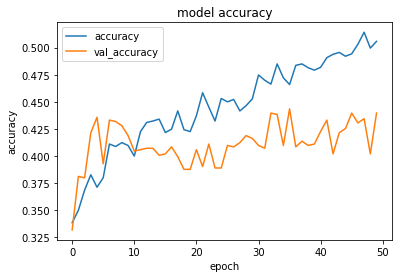

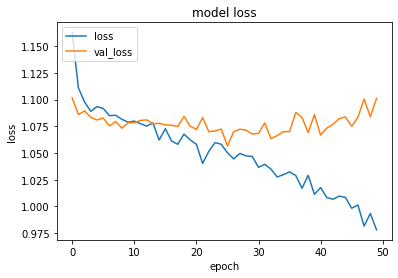

In [56]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [57]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_enc = encode_categ_data(y_test)
for i in y_test_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

In [58]:
print(y_pred[10:20])
print(y_test_enc[10:20])

[[0.33314517 0.26100594 0.40584883]
 [0.24845466 0.631346   0.1201994 ]
 [0.331639   0.30467275 0.3636882 ]
 [0.3577609  0.27368125 0.36855784]
 [0.28425473 0.56170213 0.15404312]
 [0.36028147 0.2899064  0.3498121 ]
 [0.43764406 0.28425854 0.2780974 ]
 [0.64289683 0.15814067 0.19896246]
 [0.5079369  0.19376193 0.29830122]
 [0.47132328 0.19659387 0.3320828 ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [59]:
print(pred_array[10:20])
print(real_array[10:20])

[2 1 2 2 1 0 0 0 0 0]
[0 1 1 1 1 1 0 0 0 1]


In [60]:
accuracy_score_DNN = accuracy_score(real_array, pred_array)
print('Accuracy Score - DL: ', accuracy_score_DNN)

Accuracy Score - DL:  0.360381861575179


In [61]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.35      0.33      0.34       129
           1       0.34      0.22      0.26       144
           2       0.38      0.53      0.44       146

    accuracy                           0.36       419
   macro avg       0.35      0.36      0.35       419
weighted avg       0.35      0.36      0.35       419



In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[42, 31, 56],
       [41, 31, 72],
       [38, 30, 78]], dtype=int64)

In [63]:
print('Contagem de Classes -> DNN_real_array\n')
contagem_classes(real_array, 'DNN_real_array')

Contagem de Classes -> DNN_real_array

DNN_real_array.size:  419  | cont_buy:  129  | cont_hold:  144  | cont_sell:  146


In [64]:
print('Contagem de Classes -> DNN_pred_array\n')
contagem_classes(pred_array, 'DNN_pred_array')

Contagem de Classes -> DNN_pred_array

DNN_pred_array.size:  419  | cont_buy:  121  | cont_hold:  92  | cont_sell:  206


<AxesSubplot:>

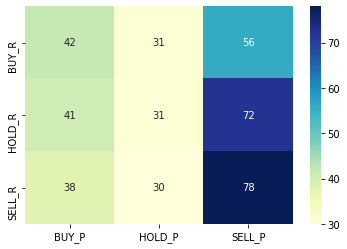

In [65]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_DNN = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

In [66]:
weightedFScore_DNN = weightedFScore(confusion_matrix)[0] 
weightedFScore_DNN

0.5564275872022102

In [67]:
y_pred_train = model_dnn.predict(x_train)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score: 0.5563


# LSTM

In [68]:
# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(LSTM(200, input_shape=(timesteps, dim), return_sequences=True))
#model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(150, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_lstm.summary())
timer.stop()


[model] Model Compiled
Time taken: 0:00:01.634537


In [69]:
'''# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(SimpleRNN(150, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(SimpleRNN(125, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(SimpleRNN(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(SimpleRNN(90, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(80, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(GRU(70, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(75, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(GRU(75, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_lstm.summary())
timer.stop()
'''

"# define and fit the final model\ntimer = Timer()\ntimer.start()\ntimesteps = configs['dataset']['sequence_length']\n\nmodel_lstm = Sequential()\n\nmodel_lstm.add(SimpleRNN(150, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(Dropout(0.1))\nmodel_lstm.add(SimpleRNN(125, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(Dropout(0.3))\nmodel_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(Dropout(0.3))\nmodel_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(Dropout(0.3))\nmodel_lstm.add(SimpleRNN(100, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(Dropout(0.3))\nmodel_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(Dropout(0.3))\nmodel_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))\nmodel_lstm.add(Dro

In [70]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_LSTM_activTanh.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_sw_enc = encode_categ_data(y_train_sw)
y_valid_sw_enc = encode_categ_data(y_valid_sw)
H = model_lstm.fit( x_train_sw, y_train_sw_enc, validation_data=(x_valid_sw, y_valid_sw_enc), epochs=15, 
                    batch_size=batch_size, callbacks=callbacks, workers=1 )

model_lstm.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started
Train on 2246 samples, validate on 759 samples
Epoch 1/15
2246/2246 [==============================] - 8s 3ms/step - loss: 1.0977 - accuracy: 0.3651 - val_loss: 1.1068 - val_accuracy: 0.3478
Epoch 2/15
2246/2246 [==============================] - 5s 2ms/step - loss: 1.0639 - accuracy: 0.4301 - val_loss: 1.1330 - val_accuracy: 0.3781
Epoch 3/15
2246/2246 [==============================] - 5s 2ms/step - loss: 1.0231 - accuracy: 0.4924 - val_loss: 1.1314 - val_accuracy: 0.3992
Epoch 4/15
2246/2246 [==============================] - 5s 2ms/step - loss: 0.9881 - accuracy: 0.5280 - val_loss: 1.2261 - val_accuracy: 0.3426
Epoch 5/15
2246/2246 [==============================] - 5s 2ms/step - loss: 0.9308 - accuracy: 0.5681 - val_loss: 1.2998 - val_accuracy: 0.4084
Epoch 6/15
2246/2246 [==============================] - 5s 2ms/step - loss: 0.8660 - accuracy: 0.6167 - val_loss: 1.2090 - val_accuracy: 0.3729
Epoch 7/15
2246/2246 [==============================] - 5s 2ms/s

In [71]:
# new instances where we do not know the answer
y_pred = model_lstm.predict(x_test_sw) 
y_pred

array([[0.14611663, 0.8094941 , 0.04438938],
       [0.10343891, 0.8672914 , 0.0292697 ],
       [0.05797909, 0.91273075, 0.02929018],
       ...,
       [0.06392668, 0.5336174 , 0.40245596],
       [0.00210066, 0.02971346, 0.96818584],
       [0.02350644, 0.10237255, 0.874121  ]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


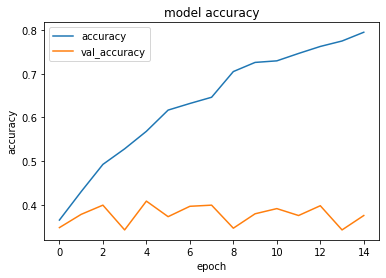

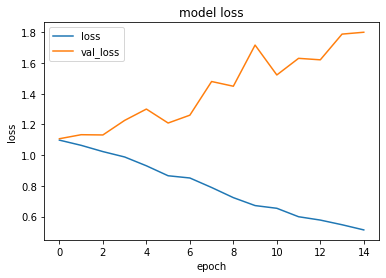

In [72]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [73]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_sw_enc = encode_categ_data(y_test_sw)
for i in y_test_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)   

In [74]:
print(y_pred[0:10])
print(pred_array[0:10])

[[0.14611663 0.8094941  0.04438938]
 [0.10343891 0.8672914  0.0292697 ]
 [0.05797909 0.91273075 0.02929018]
 [0.03588668 0.92570764 0.0384057 ]
 [0.71649396 0.19637717 0.08712882]
 [0.15599626 0.33846152 0.5055422 ]
 [0.05839557 0.20416094 0.7374435 ]
 [0.1074103  0.28833055 0.60425913]
 [0.11381851 0.22162212 0.66455936]
 [0.18893935 0.17957893 0.6314817 ]]
[1 1 1 1 0 2 2 2 2 2]


In [75]:
print(y_test_sw_enc[100:110])
print(real_array[100:110])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
[2 2 2 1 2 2 1 1 2 2]


In [76]:
accuracy_score_LSTM = accuracy_score(real_array, pred_array)
print('Accuracy Score - LSTM: ', accuracy_score_LSTM)

Accuracy Score - LSTM:  0.30900243309002434


In [77]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.27      0.17      0.21       125
           1       0.33      0.51      0.40       140
           2       0.30      0.23      0.26       146

    accuracy                           0.31       411
   macro avg       0.30      0.31      0.29       411
weighted avg       0.30      0.31      0.29       411



In [78]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[21, 63, 41],
       [29, 72, 39],
       [28, 84, 34]], dtype=int64)

In [79]:
print('Contagem de Classes -> LSTM_real_array\n')
contagem_classes(real_array, 'LSTM_real_array')

Contagem de Classes -> LSTM_real_array

LSTM_real_array.size:  411  | cont_buy:  125  | cont_hold:  140  | cont_sell:  146


In [80]:
print('Contagem de Classes -> LSTM_pred_array\n')
contagem_classes(pred_array, 'LSTM_pred_array')

Contagem de Classes -> LSTM_pred_array

LSTM_pred_array.size:  411  | cont_buy:  78  | cont_hold:  219  | cont_sell:  114


In [81]:
weightedFScore_LSTM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LSTM

0.4362652107527877

<AxesSubplot:>

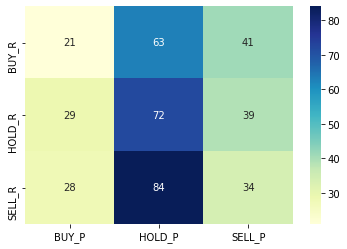

In [82]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LSTM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

In [83]:
y_pred_train_sw = model_lstm.predict(x_train_sw)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train_sw:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_train_sw_enc = encode_categ_data(y_train_sw)
for i in y_train_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score LSTM: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score LSTM: 0.8072


# Resumo

In [84]:
print('-------------Resumo-------------')

print('\nAccuracy Score - LGBM: ', accuracy_score_LGBM)
print('Weighted F Score - LGBM: ', weightedFScore_LGBM)

print('\nAccuracy Score - Random Forest: ', accuracy_score_RF)
print('Weighted F Score - Random Forest: ', weightedFScore_RF)

print('\nAccuracy Score - DNN: ', accuracy_score_DNN)
print('Weighted F Score - DNN: ', weightedFScore_DNN)

print('\nAccuracy Score - LSTM: ', accuracy_score_LSTM)
print('Weighted F Score - LSTM: ', weightedFScore_LSTM)

-------------Resumo-------------

Accuracy Score - LGBM:  0.315035799522673
Weighted F Score - LGBM:  0.4738345588578506

Accuracy Score - Random Forest:  0.34844868735083534
Weighted F Score - Random Forest:  0.5048110306517211

Accuracy Score - DNN:  0.360381861575179
Weighted F Score - DNN:  0.5564275872022102

Accuracy Score - LSTM:  0.30900243309002434
Weighted F Score - LSTM:  0.4362652107527877


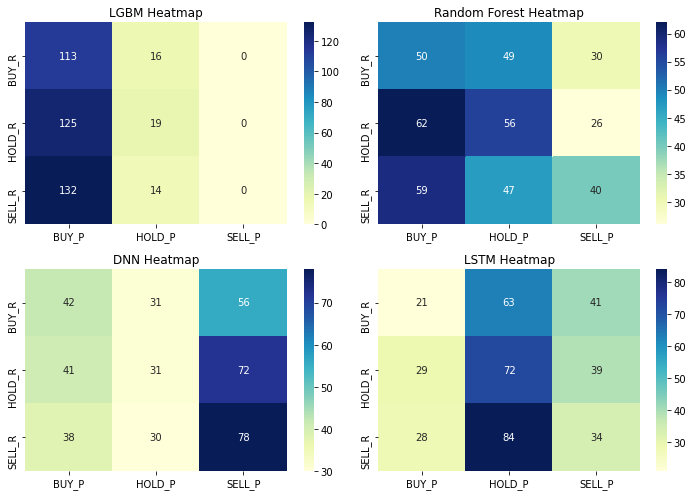

In [85]:
plt.figure(figsize=[10,7])
plt.subplot(2,2,1)
plt.title('LGBM Heatmap')
sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,2)
plt.title('Random Forest Heatmap')
sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,3)
plt.title('DNN Heatmap')
sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,4)
plt.title('LSTM Heatmap')
sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

plt.tight_layout()

In [86]:
# save trained model
#pickle.dump( model_lgbm, open( 'saved_models/model_LGBM_135features_5000.pkl', 'wb' ) )

In [87]:
#pickle.dump( model_dnn, open( 'saved_models/model_DNN_135features_50.pkl', 'wb' ) )

In [88]:
#pickle.dump( model_randomF, open( 'saved_models/model_RF_135features_5000.pkl', 'wb' ) )